In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
from scipy.special import comb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
# from patsy import dmatrices
import bff
import pingouin as pg
import researchpy

import networkx as nx

# Plotting packages
import matplotlib.pyplot as plt
plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 30

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Autosaving every 30 seconds


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [70]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("K-POP.xlsx"))
df.head()

,Response ID,CONDITION,COUNTRY,GENDER,AGE,RACE,ATTENTION,PRE,POST,Change
0,R_2ATJPnx7HxBVlzb,Exp,US,Male,16.0,White,Disagree,0.444444,0.444444,0.000000
1,R_2sRYmxwFojyZZC1,Exp,US,Male,16.0,Asian,Disagree,-1.555556,-1.666667,-0.111111
2,R_3I0iIzLfvT6ZA2W,Exp,US,Male,16.0,White,Disagree,1.777778,1.666667,-0.111111
3,R_1DS7l4ulqTDHVm5,Exp,US,Male,17.0,White,Disagree,-0.111111,-0.333333,-0.222222
4,R_1f2BXEi6TaSLedX,Exp,RO,Male,18.0,White,Disagree,-1.666667,-2.111111,-0.444444


<IPython.core.display.Javascript object>


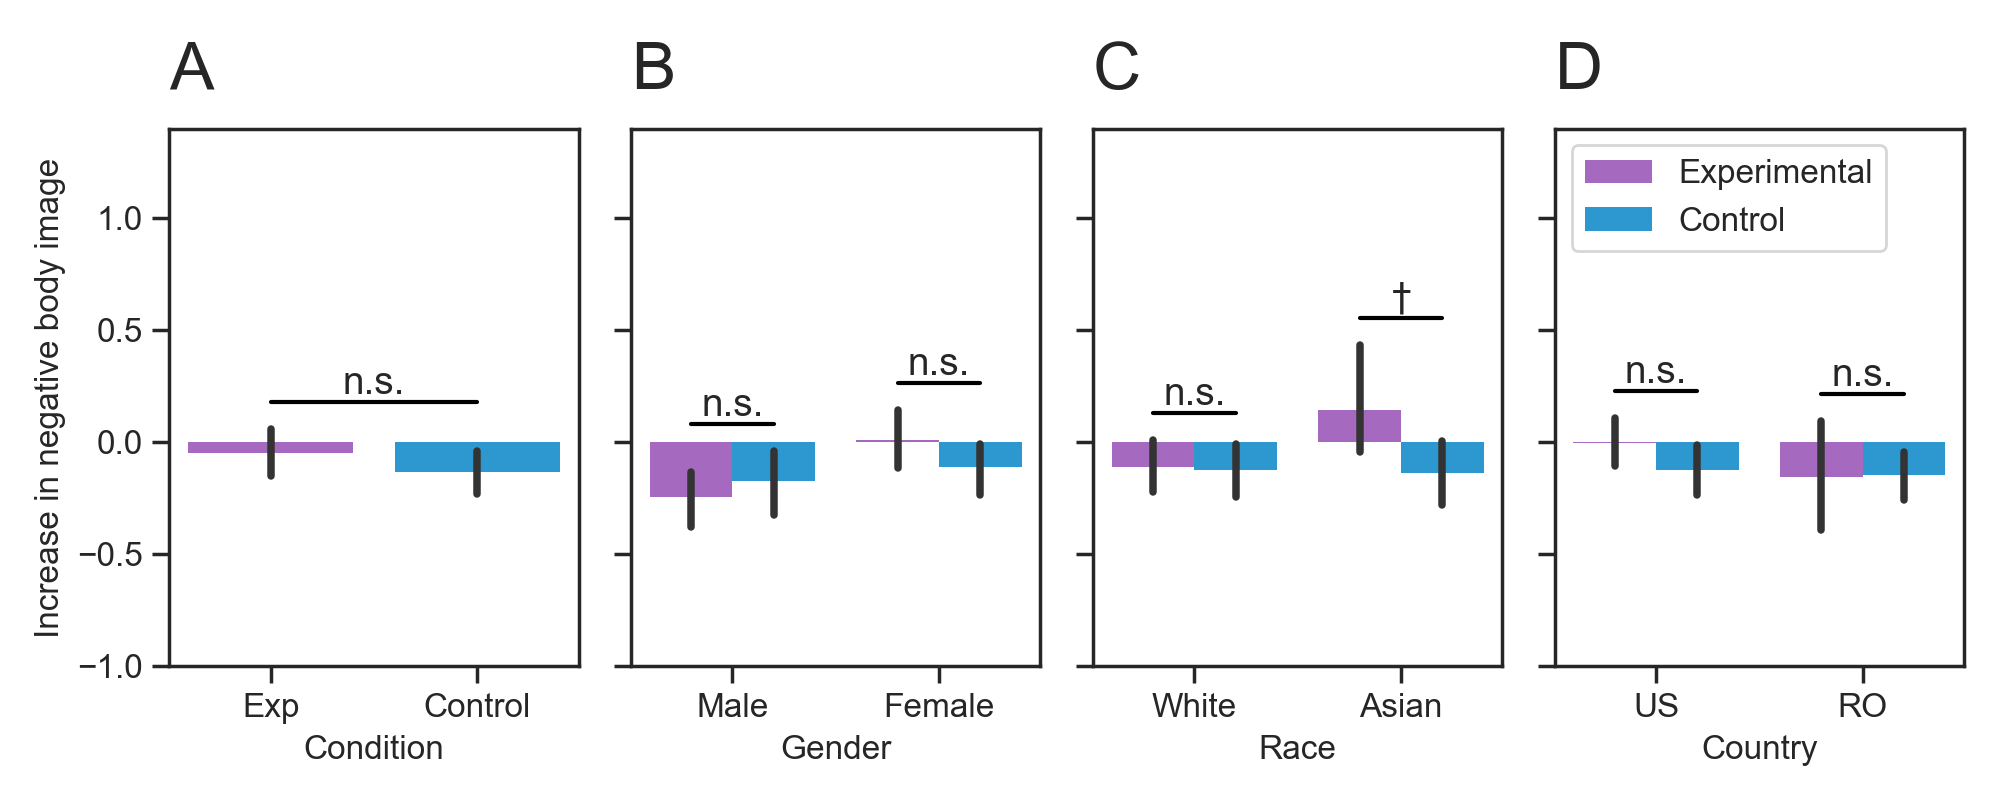

In [78]:
pp = ["#AA5ACF", "#12a1eb"]

fig, ax = plt.subplots(1,4, figsize=(10,4), sharey=True)

sns.barplot(x=df.CONDITION, y=df.Change, data=df, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0])
ax[0].set_ylabel('Increase in negative body image')
ax[0].set(xlabel='Condition')
# ax[0].set_xticklabels(["Control","Experimental"])
ax[0].set_ylim([-1,1.4])
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_ind(df.loc[df.CONDITION=="Exp", "Change"], \
                       df.loc[df.CONDITION=="Control", "Change"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=df.GENDER, y=df.Change, hue="CONDITION", data=df, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1])
ax[1].set(xlabel='Gender')
# ax[1].set_xticklabels(["Male","Female"])
ax[1].get_legend().remove()
ax[1].set_ylabel('')
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_ind(df.loc[np.logical_and(df["CONDITION"]=="Exp", df["GENDER"]==0), "Change"], \
                       df.loc[np.logical_and(df["CONDITION"]=="Control", df["GENDER"]==0), "Change"])
bff.barplot_annotate_brackets(ax[1], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_ind(df.loc[np.logical_and(df["CONDITION"]=="Exp", df["GENDER"]==1), "Change"], \
                       df.loc[np.logical_and(df["CONDITION"]=="Control", df["GENDER"]==1), "Change"])
bff.barplot_annotate_brackets(ax[1], 1, 3, p, datahandles, dh=0.05, fs=14)


sns.barplot(x=df.RACE, y=df.Change, hue="CONDITION", data=df, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2])
datahandles = np.array([L.get_xydata() for L in ax[2].get_lines()])
_, p = stats.ttest_ind(df.loc[np.logical_and(df["CONDITION"]=="Exp", df["RACE"]=='Asian'), "Change"], \
                       df.loc[np.logical_and(df["CONDITION"]=="Control", df["RACE"]=='Asian'), "Change"])
bff.barplot_annotate_brackets(ax[2], 1, 3, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_ind(df.loc[np.logical_and(df["CONDITION"]=="Exp", df["RACE"]=='White'), "Change"], \
                       df.loc[np.logical_and(df["CONDITION"]=="Control", df["RACE"]=='White'), "Change"])
bff.barplot_annotate_brackets(ax[2], 0, 2, p, datahandles, dh=0.05, fs=14)
ax[2].set(xlabel='Race')
ax[2].get_legend().remove()
ax[2].set_ylabel('')

sns.barplot(x=df.COUNTRY, y=df.Change, hue="CONDITION", data=df, \
            palette=pp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[3])
datahandles = np.array([L.get_xydata() for L in ax[3].get_lines()])
_, p = stats.ttest_ind(df.loc[np.logical_and(df["CONDITION"]=="Exp", df["COUNTRY"]=='US'), "Change"], \
                       df.loc[np.logical_and(df["CONDITION"]=="Control", df["COUNTRY"]=='RO'), "Change"])
bff.barplot_annotate_brackets(ax[3], 0, 2, p, datahandles, dh=0.05, fs=14)
_, p = stats.ttest_ind(df.loc[np.logical_and(df["CONDITION"]=="Exp", df["COUNTRY"]=='US'), "Change"], \
                       df.loc[np.logical_and(df["CONDITION"]=="Control", df["COUNTRY"]=='RO'), "Change"])
bff.barplot_annotate_brackets(ax[3], 1, 3, p, datahandles, dh=0.05, fs=14)
ax[3].set(xlabel='Country')
ax[3].legend(ax[2].patches[0:3:2], ['Experimental', 'Control'], loc="upper left")
ax[3].set_ylabel('')

bff.panellabel(ax[0], "A")
bff.panellabel(ax[1], "B")
bff.panellabel(ax[2], "C")
bff.panellabel(ax[3], "D")

plt.tight_layout()

plt.savefig('KPOP.jpg', dpi=300, format="jpg")


In [75]:
aov = pg.anova(dv='Change', between=["GENDER","CONDITION"], data=df, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,GENDER,0.384,1.0,0.384,3.399,0.068699,0.038
1,CONDITION,0.111,1.0,0.111,0.986,0.323557,0.011
2,GENDER * CONDITION,0.156,1.0,0.156,1.381,0.243120,0.016
3,Residual,9.726,86.0,0.113,NaN,NaN,NaN


In [77]:
aov = pg.anova(dv='Change', between=["CONDITION","RACE"], data=df, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,CONDITION,0.155,1.0,0.155,1.299,0.257668,0.016
1,RACE,0.196,1.0,0.196,1.650,0.202601,0.020
2,CONDITION * RACE,0.303,1.0,0.303,2.541,0.114803,0.030
3,Residual,9.644,81.0,0.119,NaN,NaN,NaN


In [79]:
aov = pg.anova(dv='Change', between=["COUNTRY","CONDITION"], data=df, detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,COUNTRY,0.135,1.0,0.135,1.152,0.286178,0.013
1,CONDITION,0.159,1.0,0.159,1.357,0.247365,0.016
2,COUNTRY * CONDITION,0.078,1.0,0.078,0.669,0.415660,0.008
3,Residual,10.053,86.0,0.117,NaN,NaN,NaN


In [80]:
ttest_ind(df.loc[df["CONDITION"]=='Exp', "Change"], \
          df.loc[df["CONDITION"]=='Control', "Change"], printres=True)

t = 1.16588, df = 86.25141, p = 0.24688, d = 0.24579, CI = (-0.05919, 0.22709)


In [81]:
ttest_ind(df.loc[np.logical_and(df["CONDITION"]=='Exp', df["RACE"]=='White'), "Change"], \
          df.loc[np.logical_and(df["CONDITION"]=='Control', df["RACE"]=='White'), "Change"], printres=True)

t = 0.13142, df = 58.82000, p = 0.89590, d = 0.03362, CI = (-0.16393, 0.18692)


In [82]:
ttest_ind(df.loc[np.logical_and(df["CONDITION"]=='Exp', df["RACE"]=='Asian'), "Change"], \
          df.loc[np.logical_and(df["CONDITION"]=='Control', df["RACE"]=='Asian'), "Change"], printres=True)

t = 1.80432, df = 15.34139, p = 0.09085, d = 0.79068, CI = (-0.03184, 0.59057)


In [84]:
ttest_ind(df.loc[np.logical_and(df["CONDITION"]=='Exp', df["GENDER"]=='Male'), "Change"], \
          df.loc[np.logical_and(df["CONDITION"]=='Control', df["GENDER"]=='Female'), "Change"], printres=True)

t = -1.50084, df = 24.82015, p = 0.14601, d = 0.43295, CI = (-0.36408, 0.09741)
